# Цель лабораторной работы
Изучить сложные способы подготовки выборки и подбора гиперпараметров на примере метода ближайших соседей<cite data-cite="ue:lab4"></cite>.

# Задание
Требуется выполнить следующие действия<cite data-cite="ue:lab4"></cite>:

1. Выбрать набор данных (датасет) для&nbsp;решения задачи классификации или регресии.
2. В&nbsp;случае необходимости проведите удаление или заполнение пропусков и кодирование категориальных признаков.
3. С&nbsp;использованием метода `train_test_split` разделите выборку на&nbsp;обучающую и тестовую.
4. Обучите модель ближайших соседей для&nbsp;произвольно заданного гиперпараметра $K$. Оцените качество модели с&nbsp;помощью трех подходящих для&nbsp;задачи метрик.
5. Постройте модель и оцените качество модели с&nbsp;использованием кросс-валидации. Проведите эксперименты с&nbsp;тремя различными стратегиями кросс-валидации.
6. Произведите подбор гиперпараметра $K$ с&nbsp;использованием `GridSearchCV` и кросс-валидации.
7. Повторите пункт&nbsp;4 для&nbsp;найденного оптимального значения гиперпараметра $K$. Сравните качество полученной модели с&nbsp;качеством модели, полученной в&nbsp;пункте&nbsp;4.
8. Постройте кривые обучения и валидации.

# Ход выполнения работы

Подключим все необходимые библиотеки и настроим отображение графиков<cite data-cite="doc:ipython,doc:seaborn"></cite>:

In [1]:
from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import median_absolute_error
from sklearn.metrics import accuracy_score, balanced_accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold, RepeatedKFold, ShuffleSplit
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.model_selection import learning_curve, validation_curve
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler

# Enable inline plots
%matplotlib inline

# Set plots formats to save high resolution PNG
from IPython.display import set_matplotlib_formats
set_matplotlib_formats("retina")

Зададим ширину текстового представления данных, чтобы в&nbsp;дальнейшем текст в&nbsp;отчёте влезал на&nbsp;А4<cite data-cite="doc:pandas"></cite>:

In [2]:
pd.set_option("display.width", 70)

## Предварительная подготовка данных

В&nbsp;качестве набора данных используются метрологические данные с&nbsp;метеостанции HI-SEAS (Hawaii Space Exploration Analog and Simulation) за&nbsp;четыре месяца (с&nbsp;сентября по&nbsp;декабрь 2016&nbsp;года)<cite data-cite="kg:srp"></cite>:

In [3]:
data = pd.read_csv("data/heart-disease-uci.zip")

Проверим полученные типы:

In [4]:
data.dtypes

age           int64
sex           int64
cp            int64
trestbps      int64
chol          int64
fbs           int64
restecg       int64
thalach       int64
exang         int64
oldpeak     float64
slope         int64
ca            int64
thal          int64
target        int64
dtype: object

Посмотрим на данные в&nbsp;данном наборе данных:

In [5]:
data.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


In [6]:
df = data

In [7]:
# autoscaler = StandardScaler()
# df = pd.DataFrame(autoscaler.fit_transform(data),columns = data.columns)

С&nbsp;такими данными уже можно работать. Проверим размер набора данных:

In [8]:
df.shape

(303, 14)

Проверим основные статистические характеристики набора данных:

In [9]:
df.describe()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
count,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000
mean,54.366337,0.683168,0.966997,131.623762,246.264026,0.148515,0.528053,149.646865,0.326733,1.039604,1.399340,0.729373,2.313531,0.544554
std,9.082101,0.466011,1.032052,17.538143,51.830751,0.356198,0.525860,22.905161,0.469794,1.161075,0.616226,1.022606,0.612277,0.498835
min,29.000000,0.000000,0.000000,94.000000,126.000000,0.000000,0.000000,71.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,47.500000,0.000000,0.000000,120.000000,211.000000,0.000000,0.000000,133.500000,0.000000,0.000000,1.000000,0.000000,2.000000,0.000000
50%,55.000000,1.000000,1.000000,130.000000,240.000000,0.000000,1.000000,153.000000,0.000000,0.800000,1.000000,0.000000,2.000000,1.000000
75%,61.000000,1.000000,2.000000,140.000000,274.500000,0.000000,1.000000,166.000000,1.000000,1.600000,2.000000,1.000000,3.000000,1.000000
max,77.000000,1.000000,3.000000,200.000000,564.000000,1.000000,2.000000,202.000000,1.000000,6.200000,2.000000,4.000000,3.000000,1.000000


Проверим наличие пропусков в&nbsp;данных:

In [10]:
df.isnull().sum()

age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          0
thal        0
target      0
dtype: int64

## Разделение данных
Разделим данные на&nbsp;целевой столбец и признаки:

In [11]:
X = df.drop("target", axis=1)
y = df["target"]

In [12]:
autoscaler = StandardScaler()
X = pd.DataFrame(autoscaler.fit_transform(X),columns = X.columns)

In [13]:
print(X.head(), "\n")
print(y.head())

        age       sex        cp  trestbps      chol       fbs  \
0  0.952197  0.681005  1.973123  0.763956 -0.256334  2.394438   
1 -1.915313  0.681005  1.002577 -0.092738  0.072199 -0.417635   
2 -1.474158 -1.468418  0.032031 -0.092738 -0.816773 -0.417635   
3  0.180175  0.681005  0.032031 -0.663867 -0.198357 -0.417635   
4  0.290464 -1.468418 -0.938515 -0.663867  2.082050 -0.417635   

    restecg   thalach     exang   oldpeak     slope        ca  \
0 -1.005832  0.015443 -0.696631  1.087338 -2.274579 -0.714429   
1  0.898962  1.633471 -0.696631  2.122573 -2.274579 -0.714429   
2 -1.005832  0.977514 -0.696631  0.310912  0.976352 -0.714429   
3  0.898962  1.239897 -0.696631 -0.206705  0.976352 -0.714429   
4  0.898962  0.583939  1.435481 -0.379244  0.976352 -0.714429   

       thal  
0 -2.148873  
1 -0.512922  
2 -0.512922  
3 -0.512922  
4 -0.512922   

0    1
1    1
2    1
3    1
4    1
Name: target, dtype: int64


In [14]:
print(X.shape)
print(y.shape)

(303, 13)
(303,)


Разделим выборку на&nbsp;тренировочную и тестовую:

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                            test_size=0.25, random_state=346705925)

In [16]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(227, 13)
(76, 13)
(227,)
(76,)


## Модель ближайших соседей для произвольно заданного гиперпараметра $K$

Напишем функцию, которая считает метрики построенной модели:

In [17]:
def test_model(model):
    print("mean_absolute_error:",
          mean_absolute_error(y_test, model.predict(X_test)))
    print("median_absolute_error:",
          median_absolute_error(y_test, model.predict(X_test)))
    print("accuracy:",
          accuracy_score(y_test, model.predict(X_test)))
    print("balanced_accuracy:",
          balanced_accuracy_score(y_test, model.predict(X_test)))

Попробуем метод ближайших соседей с&nbsp;гиперпараметром $K=5$:

In [18]:
reg_5 = KNeighborsClassifier(n_neighbors=5)
reg_5.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

Проверим метрики построенной модели:

In [19]:
test_model(reg_5)

mean_absolute_error: 0.17105263157894737
median_absolute_error: 0.0
accuracy: 0.8289473684210527
balanced_accuracy: 0.8204301075268817


Видно, что средние ошибки не&nbsp;очень показательны для&nbsp;одной модели, они больше подходят для&nbsp;сравнения разных моделей. В&nbsp;тоже время коэффициент детерминации неплох сам по&nbsp;себе, в&nbsp;данном случае модель более-менее состоятельна.

## Использование кросс-валидации

Проверим различные стратегии кросс-валидации. Для&nbsp;начала посмотрим классический K-fold:

In [20]:
scores = cross_val_score(KNeighborsClassifier(n_neighbors=5), X, y,
                         cv=KFold(n_splits=10))
print(scores)
print(scores.mean(), "±", scores.std())

[0.87096774 0.83870968 0.83870968 0.8        0.8        0.76666667
 0.66666667 0.9        0.76666667 0.53333333]
0.7781720430107527 ± 0.10216643905662431


In [21]:
scores = cross_val_score(KNeighborsClassifier(n_neighbors=5), X, y,
                         cv=RepeatedKFold(n_splits=5, n_repeats=2))
print(scores)
print(scores.mean(), "±", scores.std())

[0.81967213 0.78688525 0.83606557 0.8        0.81666667 0.90163934
 0.85245902 0.80327869 0.85       0.76666667]
0.8233333333333335 ± 0.036602478162364685


In [22]:
scores = cross_val_score(KNeighborsClassifier(n_neighbors=5), X, y,
                         cv=ShuffleSplit(n_splits=10))
print(scores)
print(scores.mean(), "±", scores.std())

[0.83870968 0.96774194 0.80645161 0.80645161 0.80645161 0.90322581
 0.83870968 0.74193548 0.93548387 0.87096774]
0.8516129032258064 ± 0.064837907233038


## Подбор гиперпараметра $K$

Введем список настраиваемых параметров:

In [23]:
n_range = np.array(range(1, 50, 1))
tuned_parameters = [{'n_neighbors': n_range}]
n_range

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49])

Запустим подбор параметра:

In [24]:
gs = GridSearchCV(KNeighborsClassifier(), tuned_parameters,
                  cv=ShuffleSplit(n_splits=10),
                  return_train_score=True)
gs.fit(X, y)
gs.best_params_

{'n_neighbors': 13}

Проверим результаты при&nbsp;разных значения гиперпараметра на&nbsp;тренировочном наборе данных:

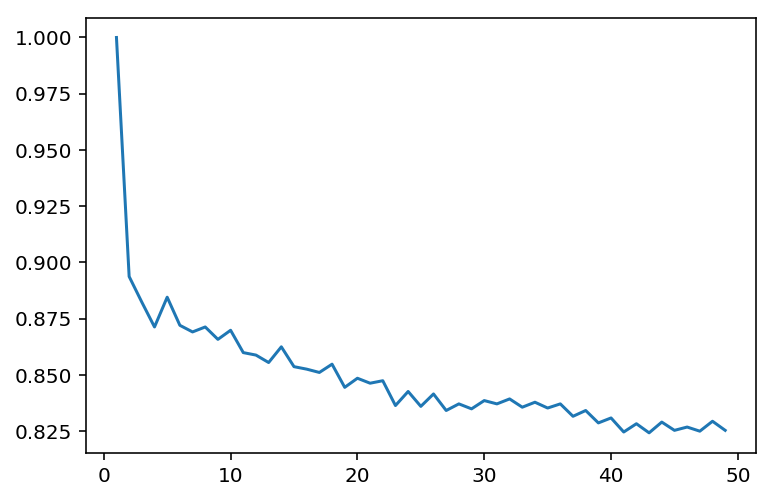

In [25]:
plt.plot(n_range, gs.cv_results_["mean_train_score"]);

Очевидно, что для&nbsp;$K=1$ на&nbsp;тренировочном наборе данных мы находим ровно ту же точку, что и нужно предсказать, и чем больше её соседей мы берём — тем меньше точность.

На&nbsp;тестовом наборе данных картина сильно интереснее:

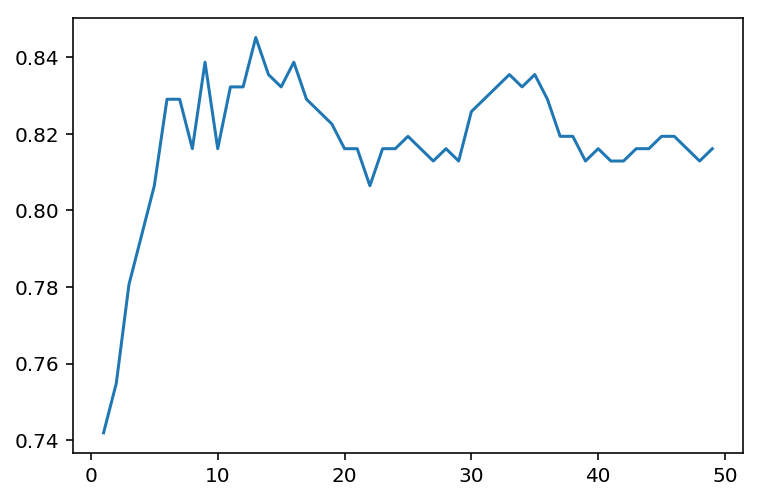

In [26]:
plt.plot(n_range, gs.cv_results_["mean_test_score"]);

Выходит, что сначала соседей слишком мало (высоко влияние выбросов), а затем количество соседей постепенно становится слишком велико, и среднее значение по&nbsp;этим соседям всё больше и больше оттягивает значение от&nbsp;истинного.

Проверим получившуюся модель:

In [27]:
reg = KNeighborsClassifier(**gs.best_params_)
reg.fit(X_train, y_train)
test_model(reg)

mean_absolute_error: 0.17105263157894737
median_absolute_error: 0.0
accuracy: 0.8289473684210527
balanced_accuracy: 0.8304659498207885


В&nbsp;целом получили примерно тот же результат. Очевидно, что проблема в&nbsp;том, что данный метод не&nbsp;может дать хороший результат для&nbsp;данной выборки.

Построим кривую обучения<cite data-cite="doc:sklearn"></cite>:

In [28]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=None):
    train_sizes=np.linspace(.1, 1.0, 5)

    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes, scoring='accuracy')
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1,
                     color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

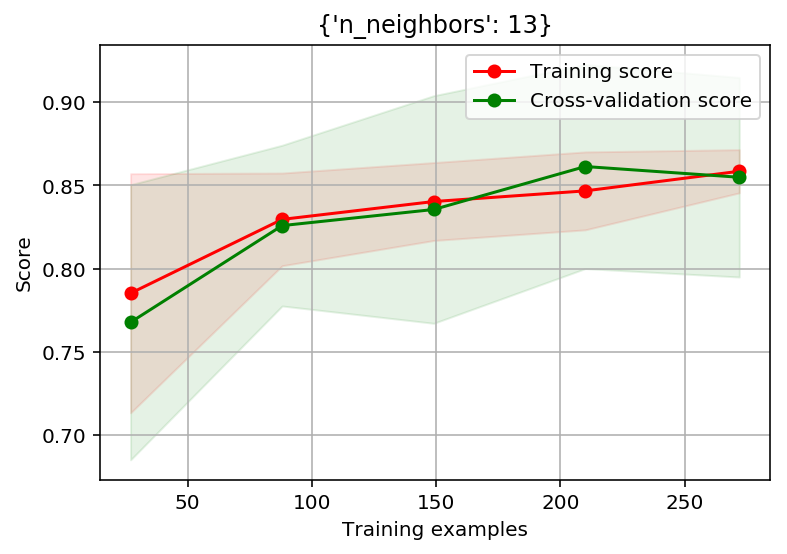

In [29]:
plot_learning_curve(reg, str(gs.best_params_), X, y,
                    cv=ShuffleSplit(n_splits=10));

Построим кривую валидации:

In [30]:
def plot_validation_curve(estimator, title, X, y, 
                          param_name, param_range, cv, 
                          scoring="accuracy"):
                                                   
    train_scores, test_scores = validation_curve(
        estimator, X, y, param_name=param_name,
        param_range=param_range,
        cv=cv, scoring=scoring, n_jobs=4)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.title(title)
    plt.xlabel(param_name)
    plt.ylabel("Score")
    plt.ylim(0.0, 1.1)
    lw = 2
    plt.plot(param_range, train_scores_mean, label="Training score",
                 color="darkorange", lw=lw)
    plt.fill_between(param_range, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.2,
                     color="darkorange", lw=lw)
    plt.plot(param_range, test_scores_mean,
                 label="Cross-validation score",
                 color="navy", lw=lw)
    plt.fill_between(param_range, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.2,
                     color="navy", lw=lw)
    plt.legend(loc="best")
    return plt

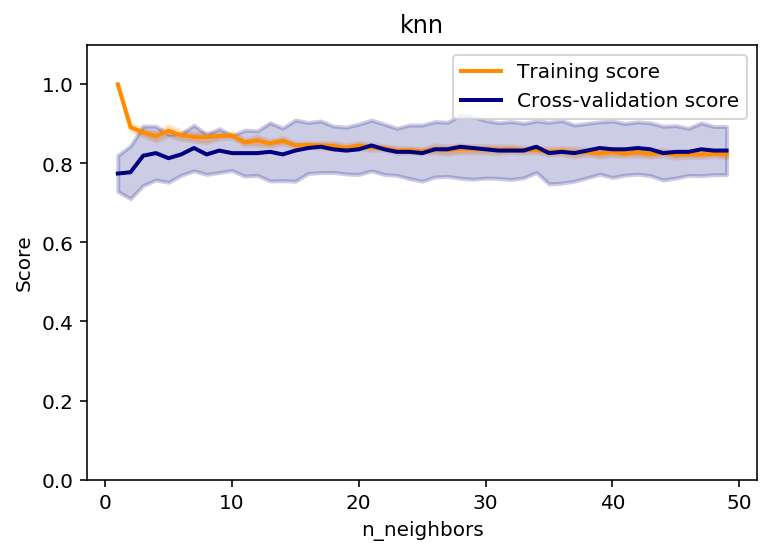

In [31]:
plot_validation_curve(KNeighborsClassifier(), "knn", X, y, 
                      param_name="n_neighbors", param_range=n_range, 
                      cv=ShuffleSplit(n_splits=10));